In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from autoviz.AutoViz_Class import AutoViz_Class
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
%matplotlib inline
plt.style.use('seaborn-white')


In [ ]:
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M')
df = pd.read_csv('OnlineRetail.csv',parse_dates=['InvoiceDate'],date_parser=dateparse)
df.head()


In [ ]:
df.info()

In [ ]:
#Check missing values
df.isnull().sum()


In [ ]:
#Description is not needed 
df.drop('Description',axis=1,inplace=True)
#There are a lot missing customer Ids . These rows are useless, we will drop them
df.dropna(subset=['CustomerID'],inplace=True)

In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

File encoding decoder utf-8 does not work for this file
Shape of your Data Set: (541909, 8)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  5
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    8 Predictors classified...
        This does not include the Target column(s)
        5 variables removed since they were ID or low-information variables
Since Number of Rows in data 541909 exceeds maximum, randomly sampling 150000 rows for EDA...
Number of All Scatter Plots = 3


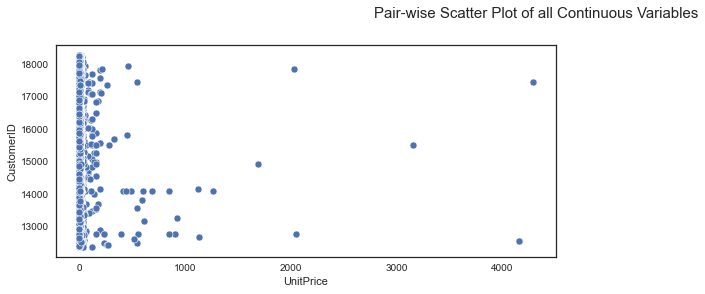

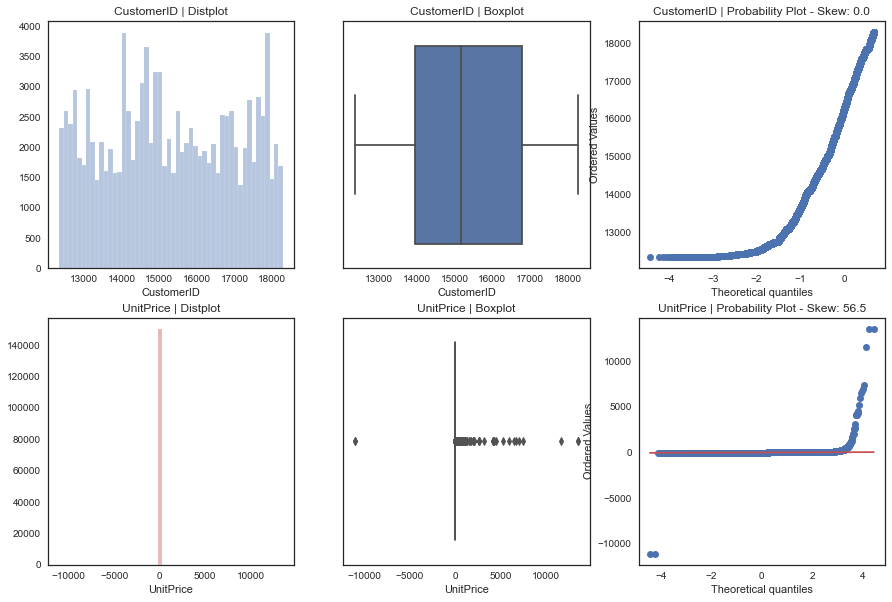

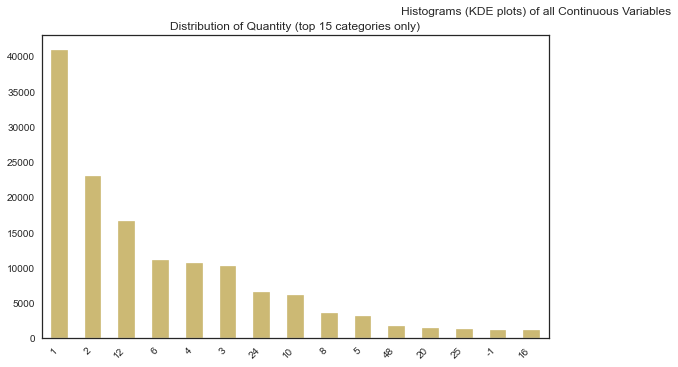

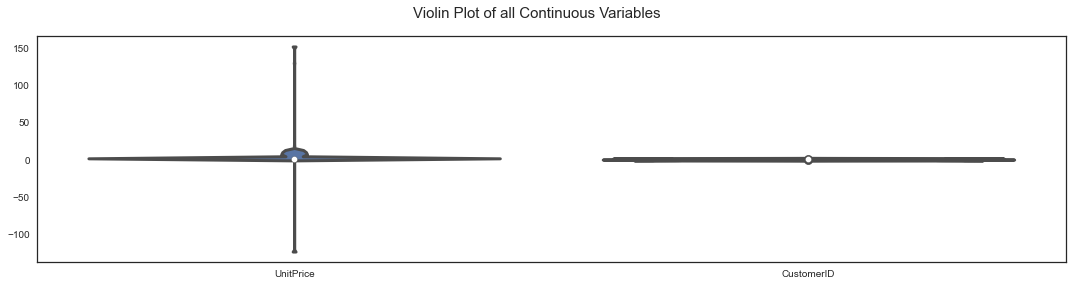

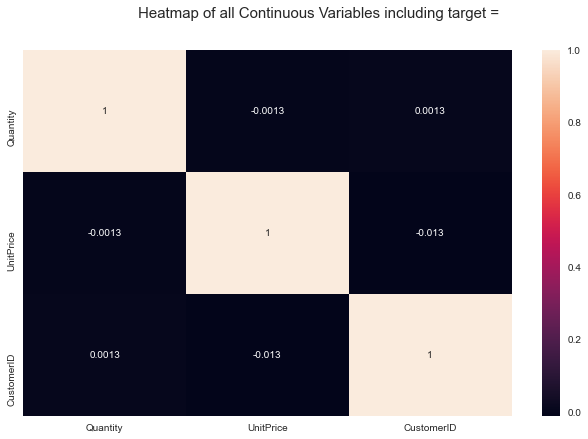

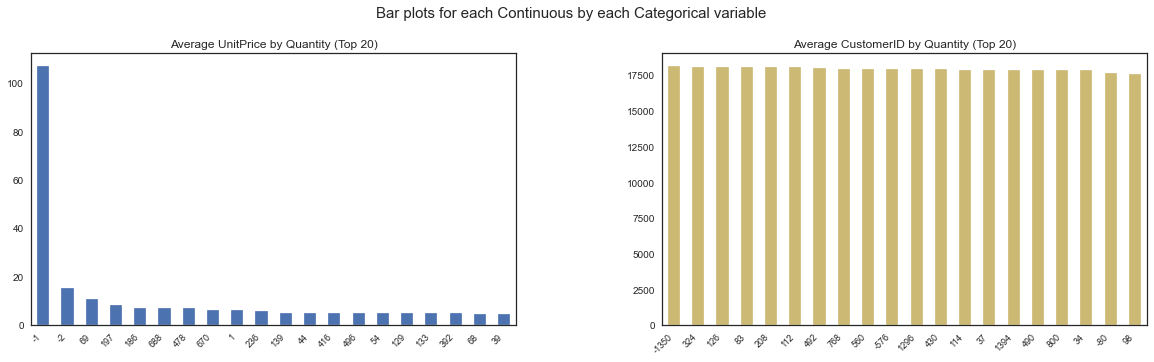

Time to run AutoViz (in seconds) = 2.961

 ###################### VISUALIZATION Completed ########################


In [35]:
#Exploratory data analysis with Pandas Profiling
profile = ProfileReport(df,explorative=True)
profile.to_notebook_iframe()

Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

Frequency (F) as total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

In [9]:
df['PurchaseAmount'] = df['UnitPrice'] * df['Quantity']
df.head()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
#Calculate total spent by customer and total orders
#Monetary (M) - Frequency (F)
spent_group = df.groupby('CustomerID')['PurchaseAmount'].sum()
spent_group.name = "Monetary"
total_orders_group = df.groupby('CustomerID')['InvoiceNo'].count()
total_orders_group.name = 'Frequency'
print(spent_group.head())
print(total_orders_group.head())

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PurchaseAmount
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [11]:
#Recency (R) - days since last purchase
#We consider the last purchase date as "today" to calculate how recent was a customer's last purchase

last_purchase_date = df['InvoiceDate'].max()
last_purchase_date
# group_last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
# group_last_purchase['Diff'] = group_last_purchase

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
Name: Monetary, dtype: float64
CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
Name: Frequency, dtype: int64


In [12]:
group_last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
group_recency =  last_purchase_date - group_last_purchase 
group_recency.name = 'Recency'
group_recency.dt.days

Timestamp('2011-12-09 12:50:00')

In [13]:
m_df = pd.DataFrame(spent_group)
rfm_df = m_df.merge(total_orders_group,left_index=True,right_index=True).merge(group_recency.dt.days,left_index=True,right_index=True)

CustomerID
12346    325
12347      1
12348     74
12349     18
12350    309
        ... 
18280    277
18281    180
18282      7
18283      3
18287     42
Name: Recency, Length: 4372, dtype: int64

In [14]:
rfm_df.head()

In [15]:
profile_rfm = ProfileReport(rfm_df,explorative=True)
profile_rfm.to_notebook_iframe()

,Monetary,Frequency,Recency
CustomerID,,,
12346,0.00,2,325
12347,4310.00,182,1
12348,1797.24,31,74
12349,1757.55,73,18
12350,334.40,17,309


In [16]:
#The profiling showed some negative monetary values . We will exclude these records
rfm_df = rfm_df[rfm_df['Monetary'] > 0]

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Scaling
scaler = StandardScaler()
rf_scaled = scaler.fit_transform(rfm_df)

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [19]:
#Determine number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(rf_scaled)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(rf_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

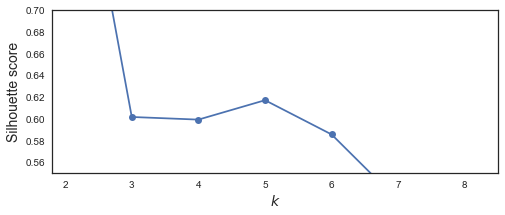

In [21]:
#Seems that 5 clusters is the optimal
kmeans = KMeans( n_clusters = 5)
preds = kmeans.fit_predict(rf_scaled)


In [22]:

skplt.metrics.plot_silhouette(rf_scaled, preds)

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

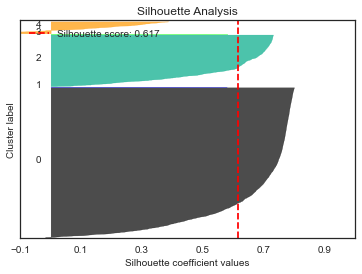

In [23]:

pred_df = pd.DataFrame(preds,columns=['Cluster'])
pred_df


In [24]:
pred_df['Cluster'].value_counts()

,Cluster
0,0
1,0
2,0
3,2
4,0
...,...
4317,2
4318,2
4319,0
4320,4


In [25]:
rfm_df['Cluster'] = pred_df.values
rfm_df

0    3030
2    1042
4     241
3       5
1       4
Name: Cluster, dtype: int64

# Some plotting to show the clustering

In [30]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Monetary'] ,
                rfm_df['Frequency'] , 
                hue = rfm_df['Cluster'] )

,Monetary,Frequency,Recency,Cluster
CustomerID,,,,
12347,4310.00,182,1,0
12348,1797.24,31,74,0
12349,1757.55,73,18,0
12350,334.40,17,309,2
12352,1545.41,95,35,0
...,...,...,...,...
18280,180.60,10,277,2
18281,80.82,7,180,2
18282,176.60,13,7,0


<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

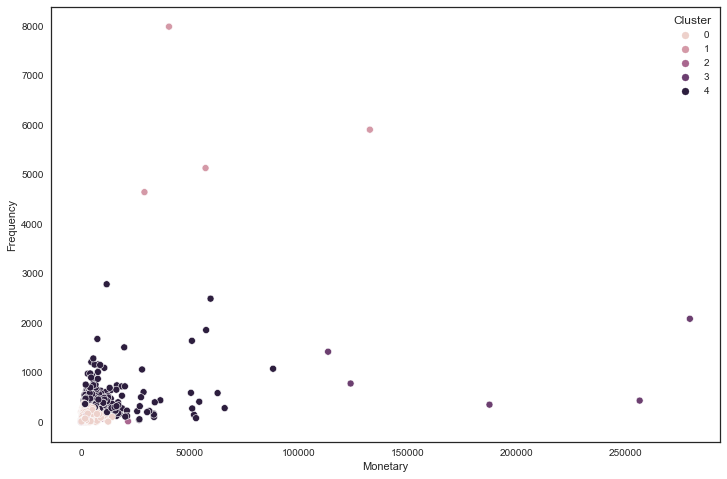

In [31]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Recency'] ,
                rfm_df['Frequency'] , 
                hue = rfm_df['Cluster'] )

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

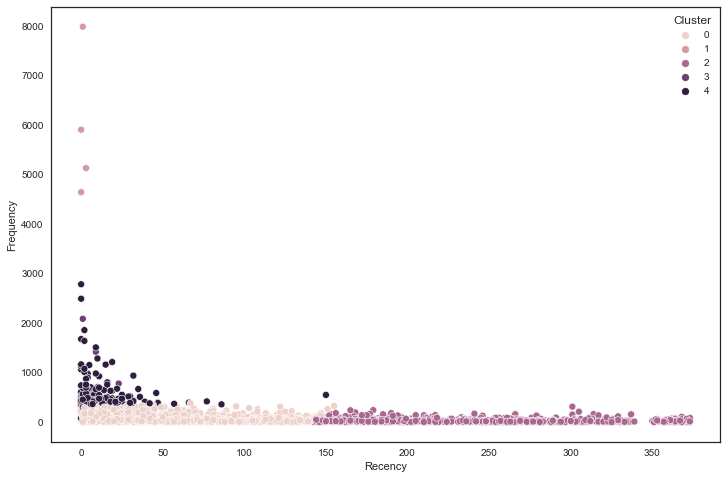

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Monetary'] ,
                rfm_df['Recency'] , 
                hue = rfm_df['Cluster'] )

There are some obvious outliers , we can potentially do further preprocessing to remove outliers

SyntaxError: invalid syntax (<ipython-input-34-a20bde262a00>, line 1)